# Computing the error between data and true model

## Import libraries

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint

## Define cell cycle model

In [20]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 0

# output_folder = "output_Live/"
# output_folder = "output_Ki67_Basic/"
output_folder = "output_Ki67_Advanced_Apoptosis/"
# output_folder = "output_Flow_Cytometry/"
# output_folder = "output_Separated_Flow_Cytometry/"

## Read *.csv* file

In [21]:
data_filename = "data_population.csv"

data = np.genfromtxt(output_folder + data_filename, dtype = float, delimiter = ',', names = True)
times = data["times"]

if cycle_model == 0:
    Ki67_negative_data = np.stack((data["Ki67_negative_mean"],), axis = -1);
    Ki67_positive_premitotic_data = np.stack((data["Ki67_positive_premitotic_mean"],), axis = -1);
    Ki67_positive_postmitotic_data = np.stack((data["Ki67_positive_postmitotic_mean"],), axis = -1);
elif cycle_model == 1:
    Ki67_negative_data = np.stack((data["Ki67_negative_mean"],), axis = -1);
    Ki67_positive_data = np.stack((data["Ki67_positive_mean"],), axis = -1);
elif cycle_model == 2:
    G0G1_phase_data = np.stack((data["G0G1_phase_mean"],), axis = -1);
    S_phase_data = np.stack((data["S_phase_mean"],), axis = -1);
    G2M_phase_data = np.stack((data["G2M_phase_mean"],), axis = -1);
elif cycle_model == 5:
    live_data = np.stack((data["live_mean"],), axis = -1);
elif cycle_model == 6:
    G0G1_phase_data = np.stack((data["G0G1_phase_mean"],), axis = -1);
    S_phase_data = np.stack((data["S_phase_mean"],), axis = -1);
    G2_phase_data = np.stack((data["G2_phase_mean"],), axis = -1);
    M_phase_data = np.stack((data["M_phase_mean"],), axis = -1);
else:
    print("Unrecognized cell cycle model.")
apoptotic_data = np.stack((data["apoptotic_mean"],), axis = -1);
necrotic_data = np.stack((data["necrotic_mean"],), axis = -1);

In [22]:
data_std_filename = "data_population_std.csv"

data_std = np.genfromtxt(output_folder + data_std_filename, dtype = float, delimiter = ',', names = True)
times = data_std["times"]

if cycle_model == 0:
    Ki67_negative_data_std = np.stack((data_std["Ki67_negative_std"],), axis = -1);
    Ki67_positive_premitotic_data_std = np.stack((data_std["Ki67_positive_premitotic_std"],), axis = -1);
    Ki67_positive_postmitotic_data_std = np.stack((data_std["Ki67_positive_postmitotic_std"],), axis = -1);
elif cycle_model == 1:
    Ki67_negative_data_std = np.stack((data_std["Ki67_negative_std"],), axis = -1);
    Ki67_positive_data_std = np.stack((data_std["Ki67_positive_std"],), axis = -1);
elif cycle_model == 2:
    G0G1_phase_data_std = np.stack((data_std["G0G1_phase_std"],), axis = -1);
    S_phase_data_std = np.stack((data_std["S_phase_std"],), axis = -1);
    G2M_phase_data_std = np.stack((data_std["G2M_phase_std"],), axis = -1);
elif cycle_model == 5:
    live_data_std = np.stack((data_std["live_std"],), axis = -1);
elif cycle_model == 6:
    G0G1_phase_data_std = np.stack((data_std["G0G1_phase_std"],), axis = -1);
    S_phase_data_std = np.stack((data_std["S_phase_std"],), axis = -1);
    G2_phase_data_std = np.stack((data_std["G2_phase_std"],), axis = -1);
    M_phase_data_std = np.stack((data_std["M_phase_std"],), axis = -1);
else:
    print("Unrecognized cell cycle model.")
apoptotic_data_std = np.stack((data_std["apoptotic_std"],), axis = -1);
necrotic_data_std = np.stack((data_std["necrotic_std"],), axis = -1);

## Solve true model numerically

In [23]:
number_of_cells = 100

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20, d, rA):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post, apoptotic = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post - d*Ki67_neg,
            r01*Ki67_neg - r12*Ki67_pos_pre - d*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post - d*Ki67_pos_post,
            d*(Ki67_neg + Ki67_pos_pre + Ki67_pos_post) - rA*apoptotic
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0, 0])
    r01 = 0.004604052
    # r01 = 0.000224164985429
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
    d = 0.000053166666667
    rA = 0.001937984496124
    true_solution = odeint(true_model, X0, times, args=(r01, r10, r12, r20, d, rA))
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0])
    r01 = 0.003631082
    r10 = 0.001075269
    true_solution = odeint(true_model, X0, times, args=(r01, r10))
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0])
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
    true_solution = odeint(true_model, X0, times, args=(r01, r20, r12))
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    X0 = np.array([number_of_cells])
    b = 0.0007198228
    true_solution = odeint(true_model, X0, times, args=(b,))
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0, 0])
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
    true_solution = odeint(true_model, X0, times, args=(r01, r30, r12, r23))
else:
    print("Unrecognized cell cycle model.")

In [24]:
if cycle_model == 0:
    Ki67_negative_true = true_solution[:,0]
    Ki67_positive_premitotic_true = true_solution[:,1]
    Ki67_positive_postmitotic_true = true_solution[:,2]
elif cycle_model == 1:
    Ki67_negative_true = true_solution[:,0]
    Ki67_positive_true = true_solution[:,1]
elif cycle_model == 2:
    G0G1_phase_true = true_solution[:,0]
    S_phase_true = true_solution[:,1]
    G2M_phase_true = true_solution[:,2]
elif cycle_model == 5:
    live_true = true_solution[:,0]
elif cycle_model == 6:
    G0G1_phase_true = true_solution[:,0]
    S_phase_true = true_solution[:,1]
    G2_phase_true = true_solution[:,2]
    M_phase_true = true_solution[:,3]
else:
    print("Unrecognized cell cycle model.")

## Plot tumor cell population for the data and true model

<Figure size 432x288 with 0 Axes>

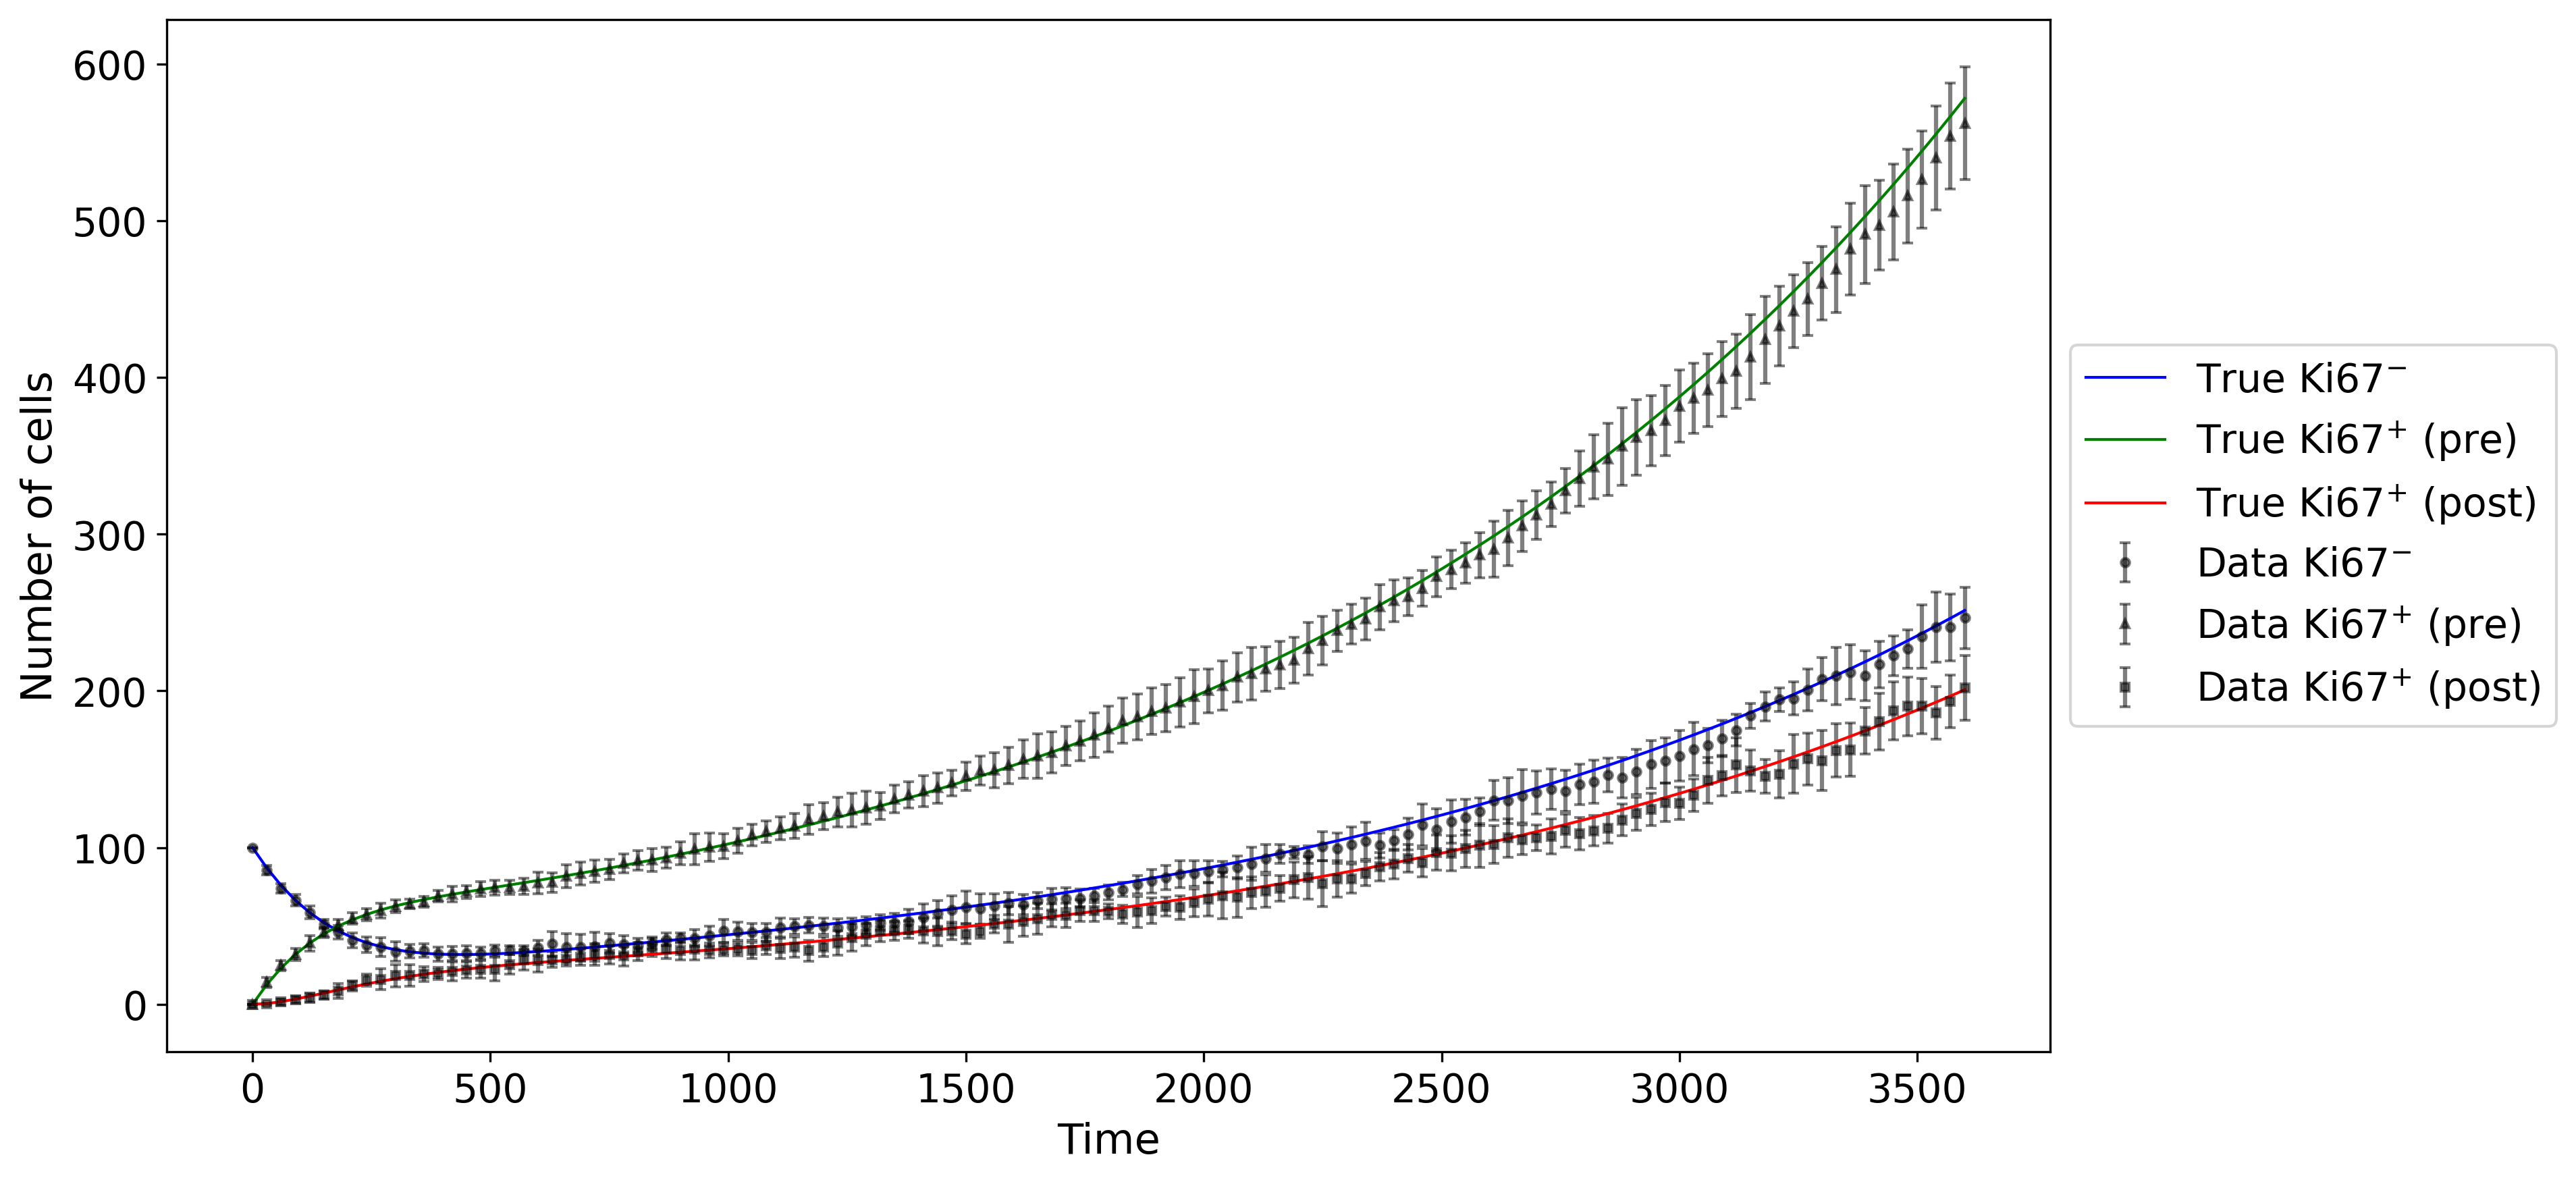

In [25]:
plt.clf()
plt.rcParams.update({'font.size': 14})
plt.subplots(1, 1, figsize = (12, 6.75), dpi = 300)
if cycle_model == 0:
    plt.errorbar(times, Ki67_negative_data, yerr = Ki67_negative_data_std[:,0], fmt = 'ko', label = r"Data Ki67$^{-}$", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, Ki67_positive_premitotic_data, yerr = Ki67_positive_premitotic_data_std[:,0], fmt = 'k^', label = r"Data Ki67$^{+}$ (pre)", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, Ki67_positive_postmitotic_data, yerr = Ki67_positive_postmitotic_data_std[:,0], fmt = 'ks', label = r"Data Ki67$^{+}$ (post)", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, Ki67_negative_true, "b", label = r"True Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_premitotic_true, "g", label = r"True Ki67$^{+}$ (pre)", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_postmitotic_true, "r", label = r"True Ki67$^{+}$ (post)", alpha = 1.0, linewidth = 1)
elif cycle_model == 1:
    plt.errorbar(times, Ki67_negative_data, yerr = Ki67_negative_data_std[:,0], fmt = 'ko', label = r"Data Ki67$^{-}$", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, Ki67_positive_data, yerr = Ki67_positive_data_std[:,0], fmt = 'k^', label = r"Data Ki67$^{+}$", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, Ki67_negative_true, "b", label = r"True Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_true, "g", label = r"True Ki67$^{+}$", alpha = 1.0, linewidth = 1)
elif cycle_model == 2:
    plt.errorbar(times, G0G1_phase_data, yerr = G0G1_phase_data_std[:,0], fmt = 'ko', label = r"Data G0/G1", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, S_phase_data, yerr = S_phase_data_std[:,0], fmt = 'k^', label = r"Data S", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, G2M_phase_data, yerr = G2M_phase_data_std[:,0], fmt = 'ks', label = r"Data G2/M", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, G0G1_phase_true, "b", label = r"True G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_true, "g", label = r"True S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2M_phase_true, "r", label = r"True G2/M", alpha = 1.0, linewidth = 1)
elif cycle_model == 5:
    plt.errorbar(times, live_data, yerr = live_data_std[:,0], fmt = 'ko', label = r"Data Live", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, live_true, "b", label = r"True Live", alpha = 1.0, linewidth = 1)
elif cycle_model == 6:
    plt.errorbar(times, G0G1_phase_data, yerr = G0G1_phase_data_std[:,0], fmt = 'ko', label = r"Data G0/G1", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, S_phase_data, yerr = S_phase_data_std[:,0], fmt = 'k^', label = r"Data S", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, G2_phase_data, yerr = G2_phase_data_std[:,0], fmt = 'ks', label = r"Data G2", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, M_phase_data, yerr = M_phase_data_std[:,0], fmt = 'kD', label = r"Data M", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, G0G1_phase_true, "b", label = r"True G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_true, "g", label = r"True S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2_phase_true, "r", label = r"True G2", alpha = 1.0, linewidth = 1)
    plt.plot(times, M_phase_true, "m", label = r"True M", alpha = 1.0, linewidth = 1)
else:
    print("Unrecognized cell cycle model.")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.title( 'Comparison of the tumor cell population', size=20)
plt.xlabel( 'Time', size=15 ) 
plt.ylabel( 'Number of cells', size=15 )
plt.savefig(os.path.join(output_folder, "population_comparison.pdf"), bbox_inches = 'tight')